mean =
 0        1.000000
1     1536.183162
2    57705.942557
3    49125.289557
4    74159.302215
5    94694.449707
dtype: float64 STD =
 0        0.000000
1      957.493093
2     9962.613444
3     6106.079767
4    20987.499187
5    29971.534763
dtype: float64


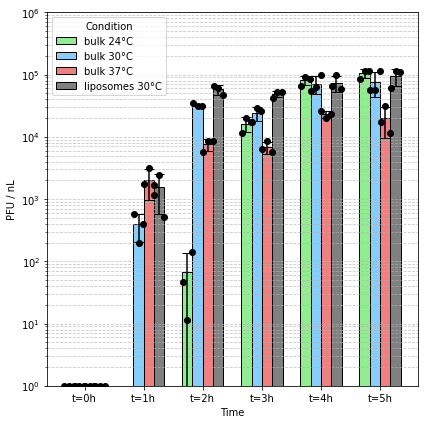

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

XLSX_PATH = Path("kinetic t7 3temp.xlsx")
SHEET = "plot"
OUTPUT_FIG = Path("pfu_per_nl_grouped_bars_log.svg")

# Desired order & legend labels
conditions = ["bulk 24°C", "bulk 30°C", "bulk 37°C", "liposomes 30°C"]
# Light fills + black edges, jittered black points (matches your example style)
colors = ["lightgreen", "lightskyblue", "lightcoral", "gray"]

# Fixed x-axis labels
time_labels = ["t=0h", "t=1h", "t=2h", "t=3h", "t=4h", "t=5h"]

# ---------- Load ----------
df = pd.read_excel(XLSX_PATH, sheet_name=SHEET)

# Find replicate columns for each condition (robust to headers like "24°C", "24°C.1", etc.)
def find_cols_for_condition(columns, cond_label):
    lab = cond_label.lower()
    out = []
    for c in columns:
        s = str(c).lower()
        if "liposomes" in lab:
            if "lipo" in s:
                out.append(c)
        else:
            # e.g., for "24°C", look for "24" and "c" anywhere in the header
            digits = "".join(ch for ch in lab if ch.isdigit())  # '24', '30', '37'
            if digits and (digits in s) and ("c" in s):
                out.append(c)
    return out

cond_to_cols = {cond: find_cols_for_condition(df.columns, cond) for cond in conditions}
missing = [cond for cond, cols in cond_to_cols.items() if len(cols) == 0]
if missing:
    raise ValueError(f"Missing replicate columns for: {', '.join(missing)}.\nFound columns: {list(df.columns)}")

# ---------- Compute mean & SD per timepoint; gather replicate arrays ----------
means, stds, rep_values = {}, {}, {}
for cond, cols in cond_to_cols.items():
    sub = df[cols].apply(pd.to_numeric, errors="coerce")
    means[cond] = sub.mean(axis=1, skipna=True)
    stds[cond]  = sub.std(axis=1, ddof=1, skipna=True)   # SD (not SEM)
    rep_values[cond] = sub.values

# Number of timepoints is the number of rows; use provided labels (trim if needed)
n_time = len(df)
x = np.arange(n_time)
tick_labels = time_labels[:n_time]

# ---------- Plot (log y-axis) ----------
bar_width = min(0.18, 0.7 / max(len(conditions), 1))
offsets = (np.arange(len(conditions)) - (len(conditions) - 1) / 2.0) * bar_width

fig_w = max(6, n_time * 0.7)
fig_h = 6
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

# Plot bars + jittered replicates
global_max = 0.0
for i, cond in enumerate(conditions):
    pos = x + offsets[i]
    m = means[cond]
    s = stds[cond]
    col = colors[i % len(colors)]
    


    # Bars with SD error bars
    ax.bar(pos, m, bar_width, label=cond, yerr=s, capsize=5, edgecolor='black', color=col)

    # Track max for y-limit
    global_max = max(global_max, np.nanmax(m + s))

    # Jittered replicate points
    vals = rep_values[cond]
    if vals.ndim == 1:
        vals = vals.reshape(-1, 1)
    n_rep = vals.shape[1]
    if n_rep > 0:
        jitter = np.linspace(-0.08, 0.08, n_rep)
        for t in range(n_time):
            row = vals[t, :]
            mask = ~np.isnan(row)
            if mask.any():
                ax.scatter(np.full(mask.sum(), pos[t]) + jitter[:mask.sum()],
                           row[mask], color='black', zorder=5)

#print(m)
print('mean =\n', m,'STD =\n', s)


# Axes cosmetics (log scale)
ax.set_xticks(x)
ax.set_xticklabels(tick_labels)
ax.set_xlabel("Time")
ax.set_ylabel("PFU / nL")

# Set log scale; choose safe y-limits (zeros cannot be shown on log scale)
ax.set_yscale("log")
y_bottom = 1.0  # minimal visible value; adjust if you prefer e.g. 0.1
if not np.isfinite(global_max) or global_max <= 0:
    y_top = 10  # fallback
else:
    y_top = 10 ** (np.ceil(np.log10(global_max)))
ax.set_ylim(bottom=y_bottom, top=y_top)

ax.legend(title="Condition")
ax.grid(axis='y', which='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()